# Non-linear Opinion Dynamics with Steepest Descent and Multiple Agents
This notebook solves for an optimal (not proved yet) policy under nonlinear opinion dynamics using steepest (gradient) descent for multiple agents.  You run the dynamics from time t=0 to t=n(# steps)*t(step size).  We use the ADAM optimization to update the policy iteratively.

INPUT:

1) Network information:

>  a) (Tweeting) Rates

>  b) Followers_list

2) Agent information:

>  a) Agent_rate = (tweeting) rate of each agent

>  b) Targets = followers of each agent

3) Opinion dynamics information:

>  a) shift = function that describes the nonlinear opinion shift as a function of the opinion difference ($x = \theta_{tweet}-\theta$). User defines this shift function

>  b) dshift = derivative of shift function with respect to opinion difference = $\frac{dshift}{dx}$

4) OBJECTIVE = type of function to maximize or minimize

> a) MEAN = Maximize mean of opinions

>   b) VARIANCE = Maximize variance of opinioins

>  c) TARGET = Minimize RMS distance of opinions from target value

OUTPUT:

1) Charts (y label vs. x label)

> a) Opinion vs. time

> b) Adjoint variable vs. time

> c) Objective function vs. # training/optimization step

> d) Opinion density vs. opinion

> User could plot w/o agent version and w/ agent version.

2) Network (directed) graph (if not too big)

> a) node=person/bot

> b) arrow=tweeting/information flow direction


# Optimal Control Approach to Influence Maximization Under Nonlinear Opinion Dynamics

Let $\theta_i(t)$ (state variable) be the opinions of user $i\in V$.  Let $\lambda_{ij}$ be the rate of tweeting from user $i$ to user $j$.  Let the opinion of the agent $k$ be $u_k(t)$ (control variable) and the agent rate to a user $i$ be $\lambda_{ki}$.  The opinion for a user $i$ follows nonlinear opinion dynamics given by 

$$\frac{d\theta_i}{dt} = \sum_{j\in V}\lambda_{ji}f(\theta_j-\theta_i) +\sum_{k} \lambda_{ki}f(u_k - \theta_i).$$ (where we assume opinion change is dependent on opinion difference and tweeting rate)

We can simplify notation by writing

$$\frac{d\theta_i}{dt} = a_i(\theta,u).$$ (where we treat $\lambda$ as constant)

For an opinion $\theta_i(t)$ define the corresponding adjoint variable $p_i(t)$.  The Hamiltonian of the system is 

$$H(\theta,p,u) = \sum_{i\in V}p_ia_i(\theta,u) $$

By Hamilon's equation, the dynamics for each opinion variable $\theta_i$ is

$$\frac{d\theta_i}{dt} = \frac{\partial H}{\partial p_i}. $$

This is referred to as the *state equation*.  You can check that it reduces to the original opinion dynmaics equation.

By Hamilton's equation, the dynamics for each adjoint/costate/dual variable $p_i$ is 

$$\frac{dp_i}{dt} = -\frac{\partial H}{\partial \theta_i}. $$

This is referred to as the *costate equation*.  Plugging in the expression for the Hamiltonian we get

$$\frac{dp_i}{dt} =  -\sum_{j\in V}p_j\lambda_{ij}\frac{\partial f(\theta_i-\theta_j)}{\partial \theta_i} - p_i\sum_{j\in V}\lambda_{ji}\frac{\partial f(\theta_j-\theta_i)}{\partial \theta_i} -
p_i\sum_k\lambda_{ki}\frac{\partial f(u_k-\theta_i)}{\partial \theta_i}. $$

If we define $g(x) = \frac{\partial f(x)}{\partial x}$ then we can rewrite the costate equation as 

$$\frac{dp_i}{dt} =  -\sum_{j\in V}p_j\lambda_{ij}g(\theta_i-\theta_j) + p_i\sum_{j\in V}\lambda_{ji}g(\theta_j-\theta_i) +
p_i\sum_k\lambda_{ki}g(u_k-\theta_i). $$

The objective function is defined on the opinions at the final time $t_f$.  Let the objective function be $h(\theta(t_f))$.  We will *minimize* this objective.  By *Pontryagin's Minimum Principle*, when we have an optimal
control $u^*(t)$, and corresponding optimal state and costate variables $\theta^*(t), p^*(t)$ then the **Hamiltonian will be minimized**.  This is, for any other control, state, and costate variables $u(t), \theta(t),p(t)$ we have 

$$H(\theta^*(t),p^*(t),u^*(t)) \leq H(\theta(t),p(t),u(t))$$.

Because our objective is only depends on the opinions at $t_f$, this puts a *boundary condition* on the costate variables at $t_f$.  Namely, 

$$p_i(t_f) = \frac{\partial h(\theta(t_f)}{\partial \theta_i(t_f)}$$.

So we see that we need to minimize the Hamiltonian while satisfying the dynamics for $\theta,p$.  To do this we will do the following steps:



1.   Simulate $\theta(t)$ given $u(t)$ given the boundary condition $\theta(0)$.
2.   Simulate $p(t)$ given $\theta(t),u(t)$ and the boundary condition for $p(t_f)$.
3.   Fore each time $t$, take a gradient of $H(\theta(t),p(t),u(t))$ with respect to $u(t)$.  We will use the ADAM optimizer step to avoid getting stuck at local minima.


That's it!  Just repeat these 3 steps over and over and you will get a decent policy.






## Mount Google Drive

The data files are located in  the Google Drive path.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/'

Mounted at /content/drive


##Import packages

In [ ]:
import numpy as np
from scipy import integrate
from scipy.integrate import odeint #not used
from scipy.sparse import coo_matrix,diags

import sympy as sm
import math
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")


## Helper functions

Functions to simulate the opinion and adjoint dynamics.



1.   step_fast() will make on step forward in the opinion dynamics given current opinions, adjoint variables P, Rates for all users, Followers_list (the network structure), agent_opinion, agent_rate, Targets_index (set of the index of all targets of the agent.  We need the index because we are dealing with arrays for the Opinions and P).
2.   simulate_opinion() will run the opinion dynamics from an initial condition Opinions0 using a time discretization size *tstep* for *nsteps* steps.

3. simulate_adjoint_resverse() will run the *adjoint dynamics* in reverse from a final condition $P_f$, with computed opinions Opinions, using a time discretization size *tstep* for *nsteps* steps.

4.  H_step_ADAM(Opinions, P, Rates, Followers_list, Agent_opinion, agent_rate, Targets_index, beta1, beta2, M_old, V_old, epsilon,t) will update the agent opinion array using the ADAM optimizer.  The update is trying to maximize the given objective.  Note that the objective only appears via the boundary condition on P at the final time.  The ADAM optimizer is merely minimizing the Hamiltonian of the system.

5. boundary_condition_Pf()
6. objective_value()
7. Plotting functions:

> a) plot_iteration()

> b) plot_opinion_P_if(): judge whether to plot total nodes or only quantiles, based on # nodes (n)

>> i) plot_opinion_P(): plot opinion chart and adjoint variable chart

>> ii) plot_opinion_P_quantiles()

> c) plot_opinion_quantiles()*2?

8. init_agent_opinion_to_min():




In [ ]:
# P = array of adjoint variables p_i
# A = adjacency matrix of the graph = nx.adjacency_matrix(G0)
def step_fast(Opinions, P, Rates, A, agent_opinions, agent_rates, Targets_indices):
  data = shift(Opinions[A.row]- Opinions[A.col],tau,omega) #shift value
  ddata = dshift(Opinions[A.row]- Opinions[A.col],tau,omega) #dshift value
  Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape) #create shift matrix in coordinate format (row index, col index, value)
  dShift_matrix = coo_matrix((ddata, (A.row, A.col)), shape=A.shape) #create dshift matrix in coordinate format (row index, col index, value)
  Rate_matrix = diags(Rates,0) #create a diagonal matrix with Rates values

  D = Rate_matrix @ Shift_matrix # matrix multiply
  Dxdt_no_agent = D.sum(axis = 0).A1 #contribution from following of node
  dD = Rate_matrix @ dShift_matrix
  dd = dD.sum(axis=0).A1
  L = P*dd #contribution from following of node (its Leaders)
  F = dD @ P  #contribution from followers of node (its Followers)
  Dxdt = Dxdt_no_agent
  Dpdt = L-F

  for (agent_opinion,agent_rate,targets_index) in zip(agent_opinions, agent_rates, Targets_indices):
    b = np.zeros(n)
    b[list(targets_index)]= agent_rate
    Dxdt_agent = b*shift(agent_opinion-Opinions,tau,omega)  #contribution from agent
    Dxdt += Dxdt_agent
    LA = P*b*dshift(agent_opinion-Opinions,tau,omega) #contribution from agent (its Leader Agent)
    Dpdt += LA
  return (Dxdt,Dpdt)

def simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_indices, nsteps, tstep):
  n =len(Opinions0)
  Opinions = np.zeros((nsteps,n))
  P = np.zeros(n)
  for i in range(nsteps):    
    if i==0:
      Opinions[i,:] = Opinions0
    else:
      agent_opinions = Agent_opinions[i-1,:]
      opinions = Opinions[i-1,:]
      (Dxdt,Dpdt) = step_fast(opinions, P, Rates, A, agent_opinions, agent_rates, Targets_indices)
      opinions_new = opinions+Dxdt*tstep
      opinions_new = np.maximum(np.minimum(opinions_new,np.ones(n)),np.zeros(n))
      Opinions[i,:] = opinions_new
  T = np.arange(0,nsteps*tstep,tstep)
  return (Opinions,T)

def simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, Targets_indices, nsteps, tstep):
  assert Agent_opinions.shape[0]==Opinions.shape[0]
  n =len(Pf)
  P = np.zeros((nsteps,n))

  for i in range(nsteps):  
    if i==0:
      P[nsteps-1-i,:] = Pf
    else:
      agent_opinions = Agent_opinions[nsteps-i,:]
      (Dxdt,Dpdt) = step_fast(Opinions[nsteps-i,:], P[nsteps-i,:], Rates, A, agent_opinions, agent_rates, Targets_indices)
      P[nsteps-1-i,:] = P[nsteps-i,:] - Dpdt*tstep
  T = np.arange(0,nsteps*tstep,tstep)
  return (P,T)


#ADAM step for a single agent.  You will have to loop over each agent.  Inputs to this function are for a single agent
def H_step_ADAM(Opinions, Agent_opinion, agent_rate, Targets_index, beta1, beta2, M_old, V_old, epsilon,t):
  (nsteps,n) = Opinions.shape
  DH = np.zeros(nsteps)
  M = np.zeros(nsteps)
  V = np.zeros(nsteps)
  Targets = list(Targets_index)

  for i in range(nsteps):
    df = dshift(Agent_opinion[i]-Opinions[i,Targets],tau,omega)
    dH0 = agent_rate*np.dot(P[i,Targets],df)
    if i ==0:
      dU = 0
    else:
      dU = 0.0*(Agent_opinion[i]-Agent_opinion[i-1])
    dH = dH0+dU
    m_old = M_old[i]
    v_old = V_old[i]
    m = beta1*m_old + (1-beta1)*dH
    v = beta2*v_old + (1-beta2)*dH**2
    m_unbias = m/(1-beta1**(t+1))
    v_unbias = v/(1-beta2**(t+1))
    dH_ADAM = m_unbias/(np.sqrt(v_unbias)+epsilon)
    DH[i] = dH_ADAM
    M[i] = m
    V[i] = v

  return (DH,M,V)


def boundary_condition_Pf(OBJECTIVE,Opinions,opinion_target = 0.5):
  if OBJECTIVE == "MEAN":
    Pf = -np.ones(n) #final adjoint value for mean objective
  elif OBJECTIVE == "VARIANCE":
    Pf = -(Opinions[-1,:] - np.mean(Opinions[-1,:])) #final adjoint value for variance objective
  elif OBJECTIVE == "TARGET":
    Pf = (Opinions[-1,:] - opinion_target) #final adjoint value for target objective
  return Pf

def objective_value(OBJECTIVE,Opinions,opinion_target):
  if OBJECTIVE == "MEAN":
    objective = -np.mean(Opinions[-1,:])  #maximize mean
  elif OBJECTIVE == "VARIANCE":
    objective = -np.var(Opinions[-1,:])  #maximize variance
  elif OBJECTIVE == "TARGET":
    objective = np.sqrt(np.mean((Opinions[-1,:]-opinion_target)**2))  #hit a target opinion
  return objective

def plot_iteration(T,Opinions,P,Agent_opinion,DH,iter):
  plt.figure(figsize =(24,4))
  plt.subplot(1,3,1)
  plt.plot(T,Opinions)
  plt.plot(T,Agent_opinion,marker='.',label='agent',color ='red')
  plt.title(f"iter = {i}")
  plt.ylabel('Opinion',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  #plt.ylim([0,1])
  plt.legend()

  plt.subplot(1,3,2)
  plt.plot(T,P)
  plt.ylabel('Adjoint variable',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  #plt.ylim([0,1])

  plt.subplot(1,3,3)
  plt.plot(T,DH,color = 'purple')
  plt.ylabel("dH/du",fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  plt.show()

def plot_opinion_P_if(T,Opinions,P,Agent_opinions,n):
  if n> 100:
    plot_opinion_P_quantiles(T,Opinions,Agent_opinions,P)
  else:
    plot_opinion_P(T,Opinions,P,Agent_opinions)

def plot_opinion_P(T,Opinions,P,Agent_opinions):
  plt.figure(figsize =(16,4))
  plt.subplot(1,2,1)
  # plt.plot(T,Opinions)
  for i in range(len(Opinions[0])):
    plt.plot(T,[Op_sub[i] for Op_sub in Opinions],label = 'Node '+str(i),linewidth=5.0) #plot node opinion
  # plt.plot(T,Agent_opinions,marker='.',label='agent',color ='red')
  for i in range(len(Agent_opinions[0])):
    plt.plot(T,[A_o_sub[i] for A_o_sub in Agent_opinions],label = 'Agent '+str(i),linewidth=1.0,color='red') #plot agent opinion
    # +(str(i) for i in targets_index) # label target nodes
  plt.ylabel('Opinion',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  # plt.ylim([0,1])
  plt.yticks(np.arange(0.0, 1.1, 0.1))
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(T,P) #plot adjoint variable
  plt.ylabel('Adjoint variable',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  plt.show()

  #print final opinion
  print('Node finals:')
  print(Opinions[-1])
  print('Agent finals:')
  print(Agent_opinions[-1])

def plot_opinion_quantiles(T,Opinions,Agent_opinions):
  Q05 = np.quantile(Opinions,0.05,axis = 1)
  Q95 = np.quantile(Opinions,0.95,axis = 1)
  Q50 = np.quantile(Opinions,0.50,axis = 1)
  Q25 = np.quantile(Opinions,0.25,axis = 1)
  Q75 = np.quantile(Opinions,0.75,axis = 1)

  plt.figure(figsize =(8,6))
  plt.subplot(1,1,1)
  plt.plot(T,Q05,color = 'black')
  plt.plot(T,Q95,color = 'black')
  plt.fill_between(T, Q05, Q95,alpha=0.2)
  plt.plot(T,Q25,color = 'black')
  plt.plot(T,Q75,color = 'black')
  plt.fill_between(T, Q25, Q75,alpha=0.2)
  plt.plot(T,Q50,color = 'blue')

  plt.plot(T,Agent_opinions,marker='.',label='agent',color ='red')
  plt.ylabel('Opinion',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  plt.ylim([0,1])
  plt.legend()
  plt.show()

def plot_opinion_quantiles(T,Opinions):
  Q05 = np.quantile(Opinions,0.05,axis = 1)
  Q95 = np.quantile(Opinions,0.95,axis = 1)
  Q50 = np.quantile(Opinions,0.50,axis = 1)
  Q25 = np.quantile(Opinions,0.25,axis = 1)
  Q75 = np.quantile(Opinions,0.75,axis = 1)

  plt.plot(T,Q05,color = 'black')
  plt.plot(T,Q95,color = 'black')
  plt.fill_between(T, Q05, Q95,alpha=0.2)
  plt.plot(T,Q25,color = 'black')
  plt.plot(T,Q75,color = 'black')
  plt.fill_between(T, Q25, Q75,alpha=0.2)
  plt.plot(T,Q50,color = 'blue')
  plt.ylabel('P',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)

def plot_opinion_P_quantiles(T,Opinions,Agent_opinion,P):
  Q05 = np.quantile(Opinions,0.05,axis = 1)
  Q95 = np.quantile(Opinions,0.95,axis = 1)
  Q50 = np.quantile(Opinions,0.50,axis = 1)
  Q25 = np.quantile(Opinions,0.25,axis = 1)
  Q75 = np.quantile(Opinions,0.75,axis = 1)

  plt.figure(figsize =(12,6))
  plt.subplot(1,2,1)
  plt.plot(T,Q05,color = 'black')
  plt.plot(T,Q95,color = 'black')
  plt.fill_between(T, Q05, Q95,alpha=0.2)
  plt.plot(T,Q25,color = 'black')
  plt.plot(T,Q75,color = 'black')
  plt.fill_between(T, Q25, Q75,alpha=0.2)
  plt.plot(T,Q50,color = 'blue')

  plt.plot(T,Agent_opinion,marker='.',label='agent',color ='red')
  plt.ylabel('Opinion',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  plt.ylim([0,1])
  plt.legend()

  P05 = np.quantile(P,0.05,axis = 1)
  P95 = np.quantile(P,0.95,axis = 1)
  P50 = np.quantile(P,0.50,axis = 1)
  P25 = np.quantile(P,0.25,axis = 1)
  P75 = np.quantile(P,0.75,axis = 1)

  plt.subplot(1,2,2)
  plt.plot(T,P05,color = 'black')
  plt.plot(T,P95,color = 'black')
  plt.fill_between(T, P05, P95,alpha=0.2)
  plt.plot(T,P25,color = 'black')
  plt.plot(T,P75,color = 'black')
  plt.fill_between(T, P25, P75,alpha=0.2)
  plt.plot(T,P50,color = 'blue')

  plt.ylabel('P',fontsize = 18)
  plt.xlabel('Time',fontsize = 18)
  plt.show()

def init_agent_opinion_to_min(nsteps, nagents, Targets):
  Agent_opinions = np.zeros((nsteps,nagents))  #initialize policy for agent 
  for cnt,targets in enumerate(Targets):
    #Make the dictionary Targets_index for faster lookup
    targets_index = set([node_index[v] for v in targets])
    Opinions_followers = Opinions[:,list(targets_index)]
    #agent opinion equals minimum of its followers at each time step
    Agent_opinions[:,cnt] = np.min(Opinions_followers,axis = 1)
  return Agent_opinions

## Shift function

Create function that gives the opinion shift and derivative of the opinion shift in the opinion dynamics.     For the opinion dynamics these functions are shift and dshift, respectively. You can have extra parameters for these functions, but the first argument is the opinion difference between the following and follower.  To be precise, if the opinion of the person tweeting
is $\theta_{tweet}$ and the opinion of the person who hears the tweet is $\theta$, then the input to the shift and dshift functions should be $x = \theta_{tweet}-\theta$. 

 



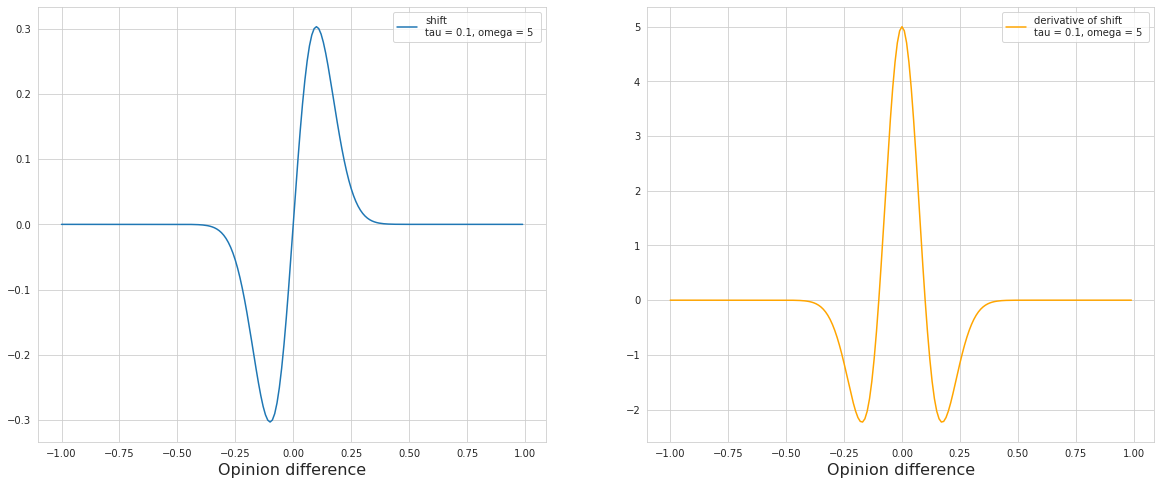

In [ ]:
#shift function f
def shift(x,tau,omega):
    y = omega *x*np.exp(-x**2/tau**2/2)
    return(y)

#derivative of shift function g
def dshift(x,tau,omega):
    y = omega*(1-x**2/tau**2)*np.exp(-x**2/tau**2/2)
    return(y)

tau = 0.1 # confidence interval, easiness to pursuade
omega = 5 # strength of persuasion
x = np.arange(-1,1,.01)

plt.figure(figsize =(20,8))
plt.subplot(1,2,1)
plt.plot(x,shift(x,tau,omega),label = f'shift\ntau = {tau}, omega = {omega} ')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.subplot(1,2,2)
plt.plot(x,dshift(x,tau,omega),label = f'derivative of shift\ntau = {tau}, omega = {omega} ',color = 'orange')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.show()

## Synthetic Network



### Define network

Rates = array of rate for each user.  Index in Rates is the identity of the user

Followers_list = array of lists of followers for each user.  Each list has the index of the follower in the Rates array

Opinions0 = array of ininital opinions in network

Targets = list of targets for the agent

Node index {1: 0, 0: 1}
Followers list [[1], []]
Targets index [[0]]
2 nodes, plus 1 agents


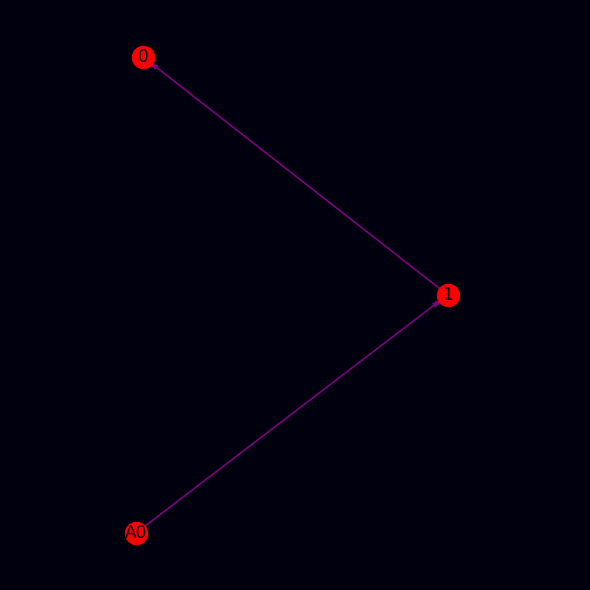

(1, 0)
('A0', 1)


In [ ]:
# Network parameters
n_newman  = 3  #number of nodes in newman network
k = 5  #number of neighbors
p = 0.1 #rewire probabilty

# G0 = nx.newman_watts_strogatz_graph(n, k, p, seed=None).to_directed()
G0 = nx.DiGraph()
# G0.add_edge(0,1)
G0.add_edge(1,0)
# G0.add_edge(0,2)
# G0.add_edge(2,0)
# G0.add_edge(1,2)
# G0.add_edge(2,1)

n = G0.number_of_nodes()
Rates = 1*np.ones(n)

# Opinions0 = np.arange(0,1,1.0/n)
Opinions0 = np.array([0.03, 0.97])

#Agent parameters
#Targets = np.arange(0,10,1)
nagents = 1
Targets = [[1]]
agent_rates = 1*np.ones(nagents)
assert nagents==len(Targets)
assert nagents==len(agent_rates)

A = nx.adjacency_matrix(G0)
# print(type(A)) #csr matrix
# print(A)
# print("----------------")
A = A.tocoo()
# print(A)
# print(A.row)
# print(A.col)

#create node_index and followers_list
node_index = {}
Followers_list = []
for cnt,v in enumerate(G0.nodes()):
  node_index[v] = cnt
for cnt,v in enumerate(G0.nodes()):
  followers = list(G0.successors(v))
  Followers_list.append([node_index[u] for u in followers])

# create target indices
Targets_index = []
for targets in Targets:
  targets_index =[]
  for v in targets:
    targets_index.append(node_index[v])
  Targets_index.append(targets_index)

print("Node index",node_index)
print("Followers list",Followers_list)
print("Targets index",Targets_index)
print(f"{n} nodes, plus {nagents} agents")

# Visualize network if ain't too big
if G0.number_of_nodes()<=100:
  G = nx.DiGraph()
  for cnt,v in enumerate(G0.nodes()):
    opinion = Opinions0[cnt]
    rate = Rates[cnt]
    G.add_node(v, Name =v, InitialOpinion=opinion, Rate=1)
    followers = G0.successors(v)
    for follower in followers:
      G.add_edge(v,follower,weight = rate)
  
  cnt = 0
  for targets,agent_rate in zip(Targets,agent_rates):
    G.add_node(f"A{cnt}")
    for v in targets:
      G.add_edge(f"A{cnt}",v, weight = agent_rate)
    cnt+=1
  edgewidth = [ 1*d['weight'] for (u,v,d) in G.edges(data=True)]

  pos = nx.kamada_kawai_layout(G)  # positions for all nodes
  pos["Agent"] = (0,-2)
  fig = plt.figure(figsize=(8,8))
  nx.draw(G, pos,width=1.5,node_color="red",edge_color="purple",node_size=500)
  nx.draw_networkx_edges(G, pos, width=edgewidth,edge_color="purple")

  nx.draw_networkx_labels(G, pos,font_size=17,font_color="black")
  fig.set_facecolor("#00000F")
  plt.show()

  for e in G.edges():
    print(e)

  #color code nodes

### General settings

In [ ]:
#Choose objective:  this will be minimized by the agent
OBJECTIVE = 'MEAN'  #OBJECTIVE can be "MEAN" (maximize mean), "VARIANCE" (maximize variance), "TARGET" (minimize RMS to target opinion)
opinion_target = 0.88 #in case you use the TARGET objective

# Select duration of simulation
tmax = 10  #tmax = tf = final time for simulation in [time units]
tstep = 0.1 #tstep = time step for the simulation in [time units]. This is dt in the Euler step.  x(t+tstep) = x(t)+tstep*dx/dt
nsteps = np.int(tmax/tstep)  #number of discrete steps in the simulation

#plot settings
np.set_printoptions(precision=2)


### Run simulation without agent

Run the opinion dynamics simulation without the agent.  This lets you see what the network will do on its own.



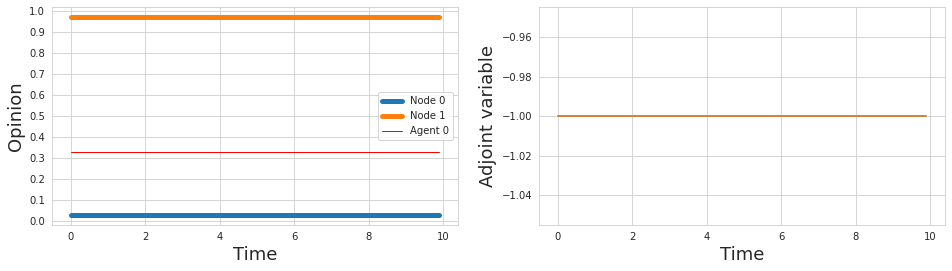

Node finals:
[0.03 0.97]
Agent finals:
[0.33]


In [ ]:
Agent_opinions = 0.33*np.ones((nsteps,nagents))  #give some dummy policy for agent 


(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, [], nsteps, tstep)

#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, [], nsteps, tstep)

plot_opinion_P_if(T,Opinions,P,Agent_opinions,n)

### Initialize Agent Opinions to minimum of their followers

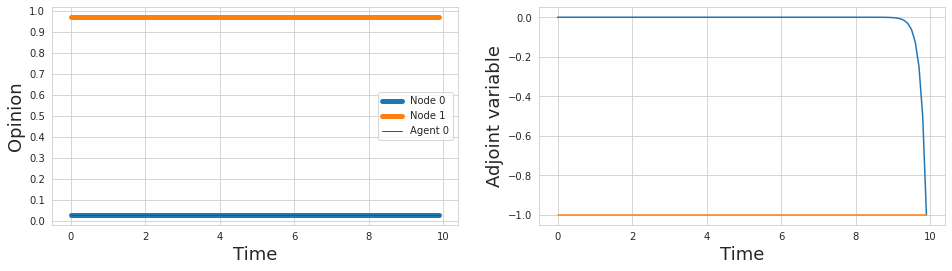

Node finals:
[0.03 0.97]
Agent finals:
[0.03]


In [ ]:
# Agent_opinions = np.zeros((nsteps,nagents))  #initialize policy for agent 

# for cnt,targets in enumerate(Targets):
#   #Make the dictionary Targets_index for faster lookup
#   targets_index = set([node_index[v] for v in targets])
#   Opinions_followers = Opinions[:,list(targets_index)]
#   #agent opinion equals minimum of its followers at each time step
#   Agent_opinions[:,cnt] = np.min(Opinions_followers,axis = 1)

Agent_opinions = init_agent_opinion_to_min(nsteps, nagents, Targets)

(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

plot_opinion_P_if(T,Opinions,P,Agent_opinions,n)

### Analytical solution for 2-1-1 (# nodes-# agents-# followers)

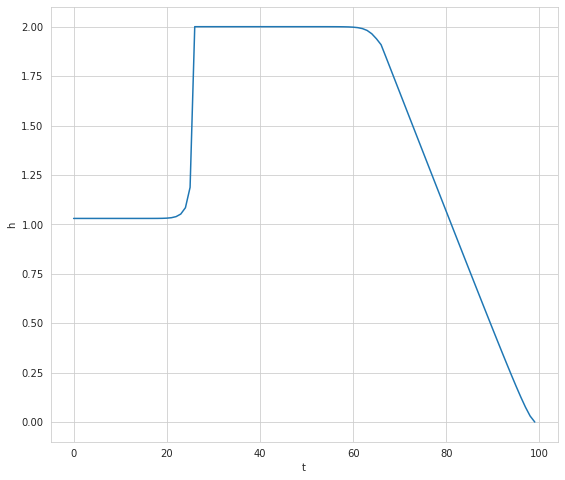

h min = -1.9999999999999973
-----------------------------
Earliest t* = 26


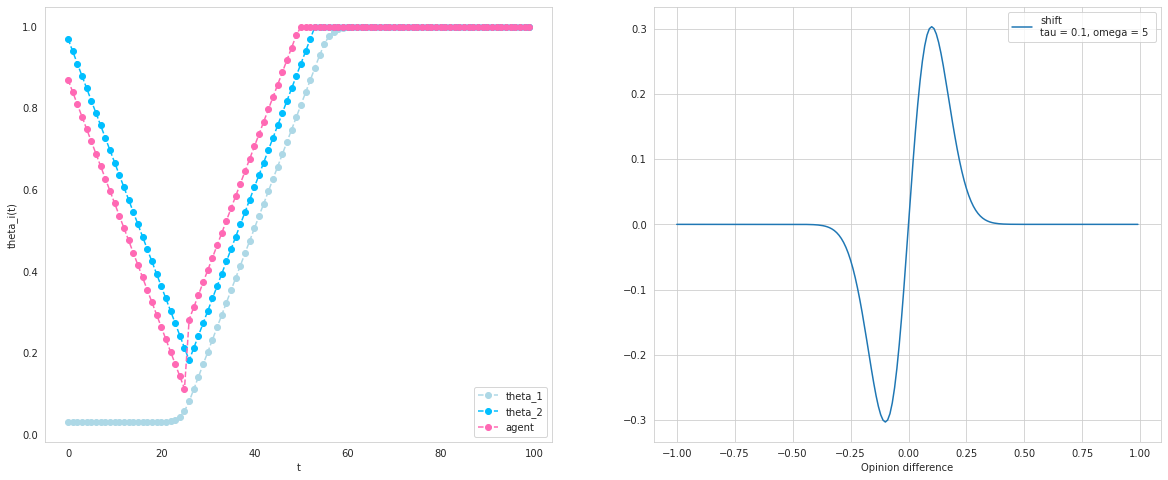

alpha = 0.3032653298563167
theta_1 (T) = 0.9999999999999972
theta_2 (T) = 1.0
h = -1.9999999999999973
agent at reflection - 1 = 0.11183667535920824
agent at reflection = 0.2815101423735765
agent at reflection + 1 = 0.3118366753592082
[-1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00
 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00
 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00 -1.03e+00
 -1.03e+00 -1.04e+00 -1.05e+00 -1.08e+00 -1.19e+00 -2.00e+00 -2.00e+00
 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00
 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00
 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00
 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00
 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -2.00e+00 -1.99e+00
 -1.98e+00 -1.96e+00 -1.94e+00 -1.91e+00 -1.85e+00 -1.79e+00 -1.73e+00
 -1.67e+00 -1.61e+00 -1.55e+00 -1.49e+00 -1.43e+00 -1.37

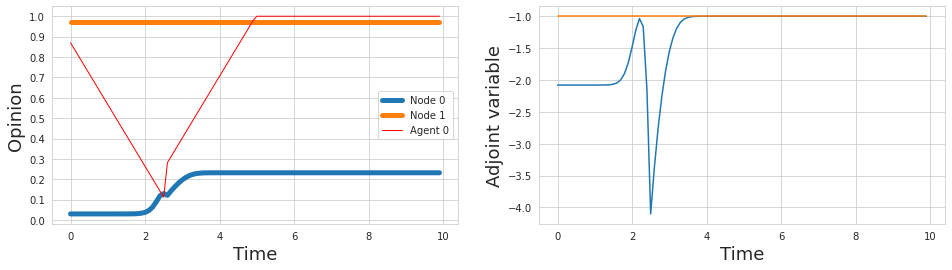

Node finals:
[0.23 0.97]
Agent finals:
[1.]


In [ ]:
from numpy.core.fromnumeric import argmin

alpha = shift(tau, tau, omega)
# Euler method
theta_1 = np.zeros(nsteps)
theta_2 = np.zeros(nsteps)
# Initial Condition
theta_1[0] = Opinions0[0]
theta_2[0] = Opinions0[1]

# store objective values in a list
nPartitions = 100
h = np.zeros(nPartitions)

for t_star_int in range(nPartitions):
  t_star = 1/nPartitions*t_star_int*nsteps
  # update thetas
  for i in range(nsteps-1):
    # update theta_2
    # 0<= t <t*
    if i < t_star-1:
      # 0<= theta_2 <=1
      if theta_2[0] - alpha*((i+1)*tstep) <= 0:
        theta_2[i+1] = 0
      elif theta_2[0] - alpha*((i+1)*tstep) >= 1:
        theta_2[i+1] = 1
      else:
        theta_2[i+1] = theta_2[0] - alpha*((i+1)*tstep)
    # t >=t*
    else:
      # 0<= theta_2 <=1
      if theta_2[0] - alpha*(t_star*tstep) <= 0:
        theta_2[i+1] = 0 + alpha*((i+1-t_star)*tstep)
      elif theta_2[0] - alpha*(t_star*tstep) + alpha*((i+1-t_star)*tstep) >= 1:
        theta_2[i+1] = 1
      else:
        theta_2[i+1] = theta_2[0] - alpha*(t_star*tstep) + alpha*((i+1-t_star)*tstep)
    if theta_2[i+1] >= 1:
      theta_2[i+1] = 1
    # update theta_1
    theta_1[i+1] = theta_1[i] + shift(theta_2[i] - theta_1[i], tau, omega)*tstep

  h[t_star_int] = -(theta_1[-1] + theta_2[-1])
  
  # encounters 1st min: break
  # if :
  #   break

plt.figure(figsize =(20,8))
plt.subplot(1,2,1)
plt.plot(range(nPartitions), -h)
plt.xlabel('t')
plt.ylabel('h')
plt.show()
print('h min = '+ str(min(h)))

# plot the earliest t* chart
t_star = argmin(h)

# agent opinion u
u = np.zeros(nsteps)
u[0] = theta_2[0] - tau
if u[i+1] < 0:
  u[i+1] = 0
elif u[i+1] > 1:
  u[i+1] = 1

# update thetas and u
for i in range(nsteps-1):
  # update theta_2 and u
  # 0<= t <t*
  if i < t_star-1:
    # 0<= theta_2 <=1
    if theta_2[0] - alpha*((i+1)*tstep) <= 0:
      theta_2[i+1] = 0
    elif theta_2[0] - alpha*((i+1)*tstep) >= 1:
      theta_2[i+1] = 1
    else:
      theta_2[i+1] = theta_2[0] - alpha*((i+1)*tstep)
    if theta_2[i+1] >= 1:
      theta_2[i+1] = 1
    # update u
    u[i+1] = theta_2[i+1] - tau
    if u[i+1] < 0:
      u[i+1] = 0
    elif u[i+1] > 1:
      u[i+1] = 1
  # t >=t*
  else:
    # 0<= theta_2 <=1
    if theta_2[0] - alpha*(t_star*tstep) <= 0:
      theta_2[i+1] = 0 + alpha*((i+1-t_star)*tstep)
    elif theta_2[0] - alpha*(t_star*tstep) + alpha*((i+1-t_star)*tstep) >= 1:
      theta_2[i+1] = 1
    else:
      theta_2[i+1] = theta_2[0] - alpha*(t_star*tstep) + alpha*((i+1-t_star)*tstep)
    if theta_2[i+1] >= 1:
      theta_2[i+1] = 1
    # update u
    u[i+1] = theta_2[i+1] + tau
    if u[i+1] < 0:
      u[i+1] = 0
    elif u[i+1] > 1:
      u[i+1] = 1
  # update theta_1
  theta_1[i+1] = theta_1[i] + shift(theta_2[i] - theta_1[i], tau, omega)*tstep

# plot nodes and agent
print('-----------------------------')
print('Earliest t* = ' + str(argmin(h)))
plt.figure(figsize =(20,8))
plt.subplot(1,2,1)
t = np.arange(0, nsteps) # number of steps
plt.plot(t, theta_1, 'bo--', label='theta_1', color='lightblue')
plt.plot(t, theta_2, 'bo--', label='theta_2', color='deepskyblue')
plt.plot(t, u, 'bo--', label='agent', color='hotpink')
plt.xlabel('t')
plt.ylabel('theta_i(t)')
plt.grid()
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(x,shift(x,tau,omega),label = f'shift\ntau = {tau}, omega = {omega} ')
plt.legend()
plt.xlabel('Opinion difference')
plt.show()

print('alpha = ' + str(alpha))
print('theta_1 (T) = ' + str(theta_1[-1]))
print('theta_2 (T) = ' + str(theta_2[-1]))
print('h = ' + str(-theta_1[-1]-theta_2[-1]))
print('agent at reflection - 1 = ' + str(u[t_star-1]))
print('agent at reflection = ' + str(u[t_star]))
print('agent at reflection + 1 = ' + str(u[t_star+1]))

print(h)

# Bug:

# double check the dynamics evolution
Agent_opinions = init_agent_opinion_to_min(nsteps, nagents, Targets)
Agent_opinions[:,0] = u

(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

plot_opinion_P_if(T,Opinions,P,Agent_opinions,n)

### Find optimal policy via ADAM

Run this loop to iteratively improve the agent_opion policy using
ADAM.  You will have to choose the step size for the gradient step, the ADAM parameters, and the initial guess of the agent_opinion.  It's best to set the agent's opinion equal to the minumum or maximum initial opinion.  This way you have some gradient to start with.

Iter. 0: objective = -0.3750


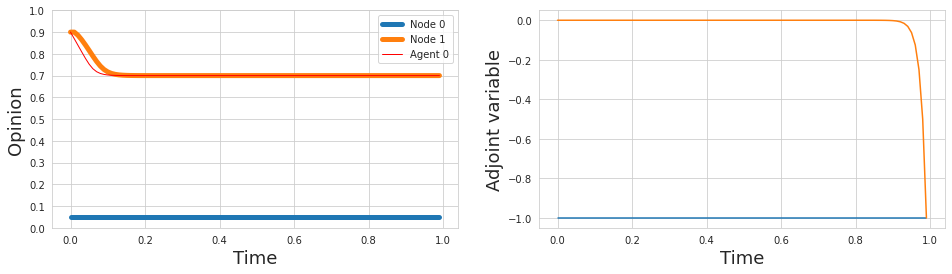

Node finals:
[0.05 0.7 ]
Agent finals:
[0.7]
Iter. 10: objective = -0.5461


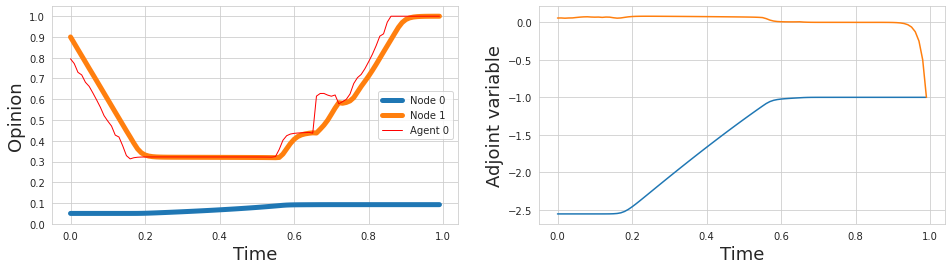

Node finals:
[0.09 1.  ]
Agent finals:
[1.]
Iter. 20: objective = -0.6543


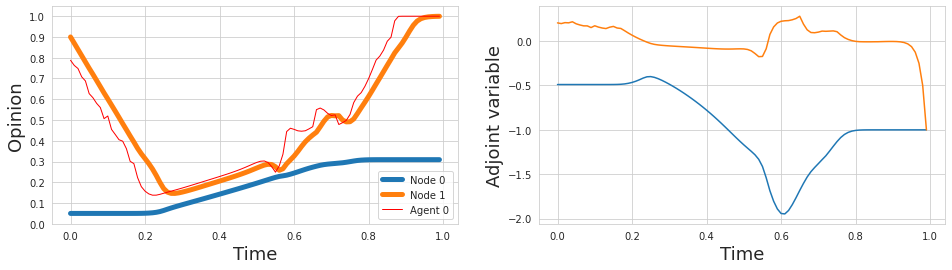

Node finals:
[0.31 1.  ]
Agent finals:
[1.]
Iter. 30: objective = -0.7033


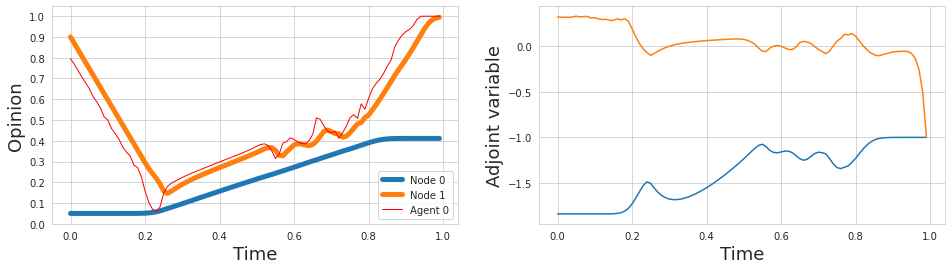

Node finals:
[0.41 1.  ]
Agent finals:
[1.]
DONE WITH LEARNING POLICY!!


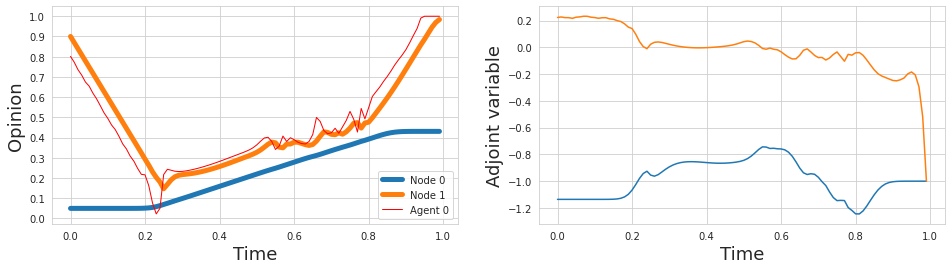

Node finals:
[0.43 0.98]
Agent finals:
[1.]
MEAN = -0.7075160066832783
----------------------------------
Smoothed ADAM:
----------------------------------
Simple moving average, window size = 60


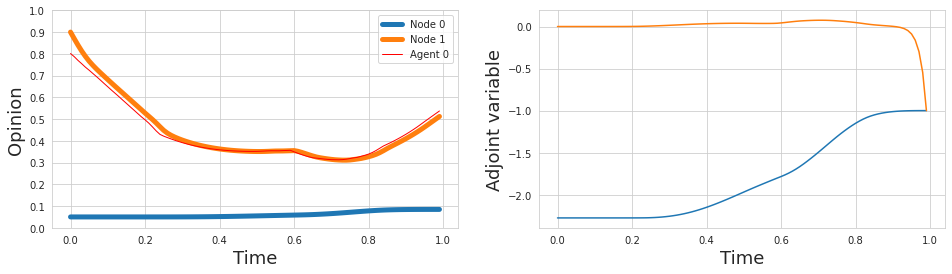

Node finals:
[0.08 0.51]
Agent finals:
[0.54]
MEAN = -0.29835146883932917
After smoothing / before smoothing = 0.42168864876704776
----------------------------------
Dynamic moving average, change tolerance = 0.01


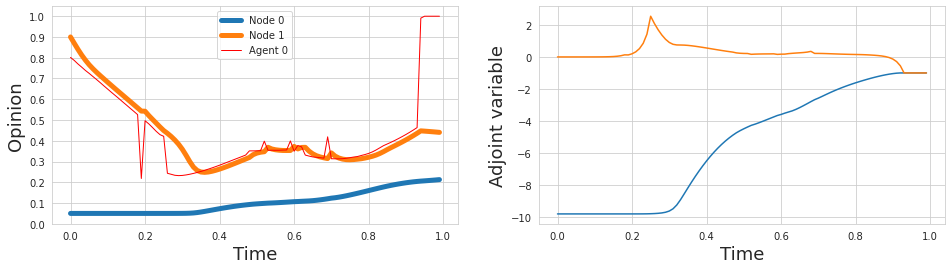

Node finals:
[0.21 0.44]
Agent finals:
[1.]
MEAN = -0.3266558339645753
After smoothing / before smoothing = 0.4616939134647787
----------------------------------
Exponential moving average, alpha = 0.05


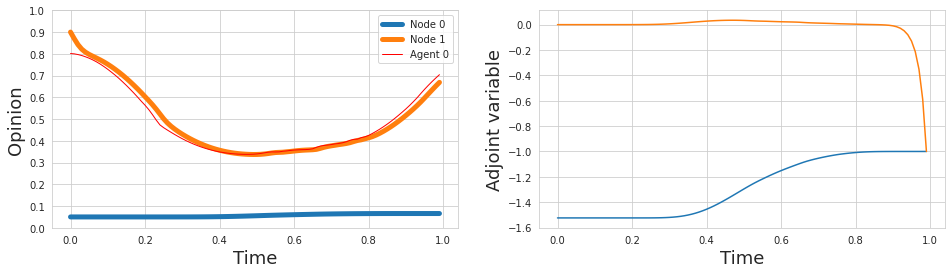

Node finals:
[0.07 0.67]
Agent finals:
[0.7]
MEAN = -0.3672295101425242
After smoothing / before smoothing = 0.5190405682325653
CPU times: user 22.9 s, sys: 224 ms, total: 23.2 s
Wall time: 26.7 s


In [ ]:
%%time
#Set gradient step size and number of gradient step iterations
alpha = 0.1
niter = 40  #number of iterations for ADAM optimizer
plot_step = 10  #how frequently to plot agent opinion
STOP_TOLERANCE = 1e-3  #fractional change in objective you will stop at
#ADAM parameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

#Initialize ADAM parameters
M_old = np.zeros((nsteps,nagents))
V_old = np.zeros((nsteps,nagents))

#Initialize objective array
Objective = np.zeros(niter)
objective_old = 0

#Initialize array of Agent opinions for each iteration.  We can use this to see our agent get smarter
Agent_opinion_iterations = np.zeros((nsteps,nagents,niter))

#Initialize agent opinions
Agent_opinions = init_agent_opinion_to_min(nsteps, nagents, Targets)

for i in range(0,niter):
  #add current agents policy at current iteration
  for cnt in range(nagents):
    Agent_opinion_iterations[:,cnt,i] = Agent_opinions[:,cnt]

  #simulate opinion dynamics
  (Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
  #Set boundary condition on adjoint (depends on objective)
  Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
  (P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
  
  #update objective
  objective = objective_value(OBJECTIVE, Opinions, opinion_target)
  Objective[i] = objective
  
  #plot opinions under current agent opinion policy
  if i%plot_step==0:
    print(f"Iter. {i}: objective = {objective:.4f}")
    #print(f"\tgrad step  {grad_step:.5f}")
    plot_opinion_P_if(T, Opinions, P, Agent_opinions, n)

  # check if objective changed sufficiently.  If it didnt, STOP
  normalized_change = np.abs(objective_old-objective)/(1e-10 + np.abs(objective_old))
  if normalized_change<0*STOP_TOLERANCE:
    print(f"Iter. {i}: objective = {objective:.2f}: STOP")
    break

  
  # If we didnt STOP, let's update the agent's opinion policy
  Agent_opinions_new = np.zeros((nsteps,nagents))
  for cnt in range(nagents):
    #update agent opinion policy using ADAM update rule
    grad_step = alpha/np.sqrt(i+1)  #the step size you multiply by the ADAM gradient to get the update for the agent policy
    (DHa, Ma, Va) = H_step_ADAM(Opinions, Agent_opinions[:,cnt], agent_rates[cnt], Targets_index[cnt], beta1, beta2, M_old[:,cnt], V_old[:,cnt], epsilon,i)
    
    #clip DH to avoid huge oscillations in the updated policy
    DHa_clip =  np.maximum(-0.1,np.minimum(0.1,grad_step*DHa))
    Agent_opinions_new[:,cnt] = Agent_opinions[:,cnt] - DHa_clip

    #Clip the agent opinion so it is between 0 and 1
    Agent_opinions_new = np.maximum(0,np.minimum(1,Agent_opinions_new))
    M_old[:,cnt] = Ma
    V_old[:,cnt] = Va
  
  #update the agent opinions and the old objective
  Agent_opinions = Agent_opinions_new  
  objective_old = objective


print("DONE WITH LEARNING POLICY!!")
#run simulation with final agent opinion
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
#Set boundary condition on adjoint (depends on objective)
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse with boundary condition Pf at time tf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions,agent_rates, Targets_index, nsteps, tstep)
plot_opinion_P_if(T, Opinions, P, Agent_opinions, n)

# #plot optimal agent policy and opinion dynamics
# plt.figure(figsize =(16,4))
# plt.subplot(1,2,1)
# plt.plot(T,Agent_opinions,marker='.',label='final agent',color ='red')
# plt.plot(T,Opinions)
# plt.title("tau = %.2f"%tau)
# plt.ylabel('Opinion',fontsize = 18)
# plt.xlabel('Time',fontsize = 18)
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(T,P)
# plt.ylabel('Adjoint variable',fontsize = 18)
# plt.xlabel('Time',fontsize = 18)
# plt.show()


#plot results
# print('Plot results:')
# plt.figure(figsize =(16,4))
# for i in range(Agent_opinion_iterations.shape[2]):
#   if i%plot_step==0:
#     plt.plot(T,Agent_opinion_iterations[:,:,i],label=f"Iter. {i}")
# plt.plot(T,Agent_opinion_iterations[:,:,i],label=f"Iter. {i}")
# plt.legend()
# plt.ylabel('Agent opinion')
# plt.xlabel('Time')
# plt.ylim([0,1])

# plt.figure(figsize =(12,8))
# plt.plot(-Objective,marker='.',color = 'red')
# plt.xticks(fontsize = 18)
# plt.yticks(fontsize = 18)

# plt.ylabel(f"{OBJECTIVE}",fontsize = 24)
# plt.xlabel('Training iteration',fontsize = 24)
# plt.show()

obj_before_smooth = Objective[niter-1]
print(OBJECTIVE + ' = ' + str(obj_before_smooth))


#smooth Agent_opinions
print('----------------------------------')
print('Smoothed ADAM:')

#simple moving average
print('----------------------------------')
window_size = 60 #number of sample points
print(f'Simple moving average, window size = {window_size}')
A_o_df = pd.DataFrame(Agent_opinions)
Agent_opinions_ma = A_o_df.rolling(window_size, min_periods=1).mean() #simple moving average
Agent_opinions_ma = Agent_opinions_ma.to_numpy() #convert dataframe to nparray, in order to pass into plot_opinion_P()
#simulate dynamics by the smoothed ADAM
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions_ma, agent_rates, Targets_index, nsteps, tstep)
#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions_ma, agent_rates, Targets_index, nsteps, tstep)
plot_opinion_P_if(T, Opinions, P, Agent_opinions_ma, n)
#update objective
obj_after_smooth = objective_value(OBJECTIVE, Opinions, opinion_target)
print(OBJECTIVE + ' = ' + str(obj_after_smooth))
print('After smoothing / before smoothing = ' + str(obj_after_smooth/obj_before_smooth))

#dynamic moving average
print('----------------------------------')
change_tolerance = 1/nsteps
print(f'Dynamic moving average, change tolerance = {change_tolerance}')
A_o_df = pd.DataFrame(Agent_opinions)
Agent_opinions_ma = A_o_df.rolling(window_size, min_periods=1).mean() #simple moving average
Agent_opinions_ma = Agent_opinions_ma.to_numpy() #convert dataframe to nparray, in order to pass into plot_opinion_P()
#change >= change_tolerance --> smooth, otherwise --> keep ADAM value
Agent_opinions_dma = np.zeros((len(Agent_opinions), nagents))
flag_dma = 0 #flag to indicate whether the current cell value is ma (1) or original ADAM (0)
for i in range(len(Agent_opinions)): #i=0~499
  if i+1 == len(Agent_opinions):
    if flag_dma == 1:
      Agent_opinions_dma[i] = Agent_opinions_ma[i]
      flag_dma = 0
    else:
      Agent_opinions_dma[i] = Agent_opinions[i]
    break
  elif abs(Agent_opinions[i+1] - Agent_opinions[i]) >= change_tolerance:
    Agent_opinions_dma[i] = Agent_opinions_ma[i]
    flag_dma = 1
  else:
    Agent_opinions_dma[i] = Agent_opinions[i]
    flag_dma = 0
#simulate dynamics by the smoothed ADAM
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions_dma, agent_rates, Targets_index, nsteps, tstep)
#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions_dma, agent_rates, Targets_index, nsteps, tstep)
plot_opinion_P_if(T, Opinions, P, Agent_opinions_dma, n)
#update objective
obj_after_smooth = objective_value(OBJECTIVE, Opinions, opinion_target)
print(OBJECTIVE + ' = ' + str(obj_after_smooth))
print('After smoothing / before smoothing = ' + str(obj_after_smooth/obj_before_smooth))


#exponential moving average
print('----------------------------------')
emv_alpha = 0.05
print(f'Exponential moving average, alpha = {emv_alpha}')
A_o_df = pd.DataFrame(Agent_opinions)
Agent_opinions_ma = A_o_df.ewm(alpha=emv_alpha, adjust=False).mean() #exponential moving average
Agent_opinions_ma = Agent_opinions_ma.to_numpy() #convert dataframe to nparray, in order to pass into plot_opinion_P()
#simulate dynamics by the smoothed ADAM
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions_ma, agent_rates, Targets_index, nsteps, tstep)
#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions_ma, agent_rates, Targets_index, nsteps, tstep)
plot_opinion_P_if(T, Opinions, P, Agent_opinions_ma, n)
#update objective
obj_after_smooth = objective_value(OBJECTIVE, Opinions, opinion_target)
print(OBJECTIVE + ' = ' + str(obj_after_smooth))
print('After smoothing / before smoothing = ' + str(obj_after_smooth/obj_before_smooth))

#what if I smooth for two times? Consecutive simple moving average

#dynamic window sizes

#machine learns the parameter value (window_size, emv_alpha)

#tail stronger weights

#introduce new agents

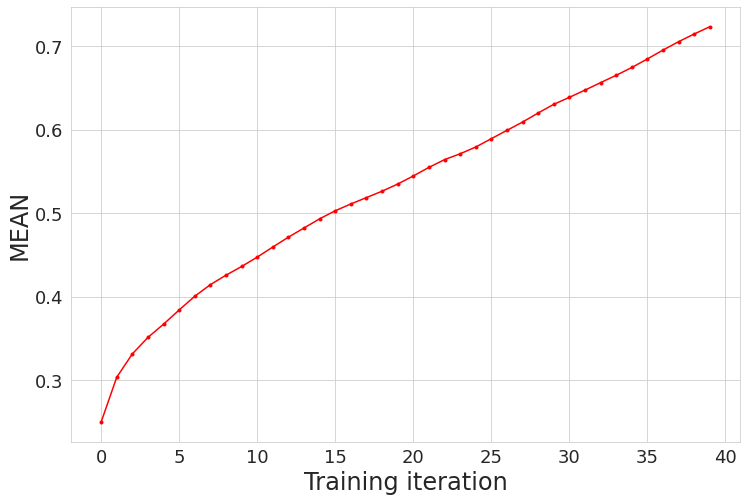

In [ ]:
plt.figure(figsize =(12,8))
plt.plot(-Objective,marker='.',color = 'red')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.ylabel(f"{OBJECTIVE}",fontsize = 24)
plt.xlabel('Training iteration',fontsize = 24)
plt.show()

###Resource

In [ ]:
# Moving average
https://towardsdatascience.com/moving-averages-in-python-16170e20f6c
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html


### odeint example

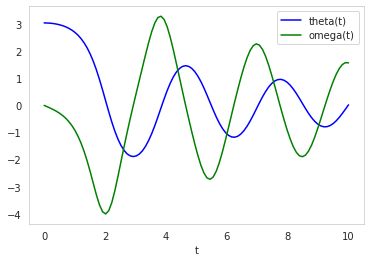

(100, 2)

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
# Solve a system of ordinary differential equations using lsoda from the FORTRAN library odepack.
def pend(y, t, b, c):
  theta, omega = y
  dydt = [omega, -b*omega - c*np.sin(theta)]
  return dydt

b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 100)
from scipy.integrate import odeint
sol = odeint(pend, y0, t, args=(b, c))

import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

sol.shape

### Plot opinions without and with trained agent

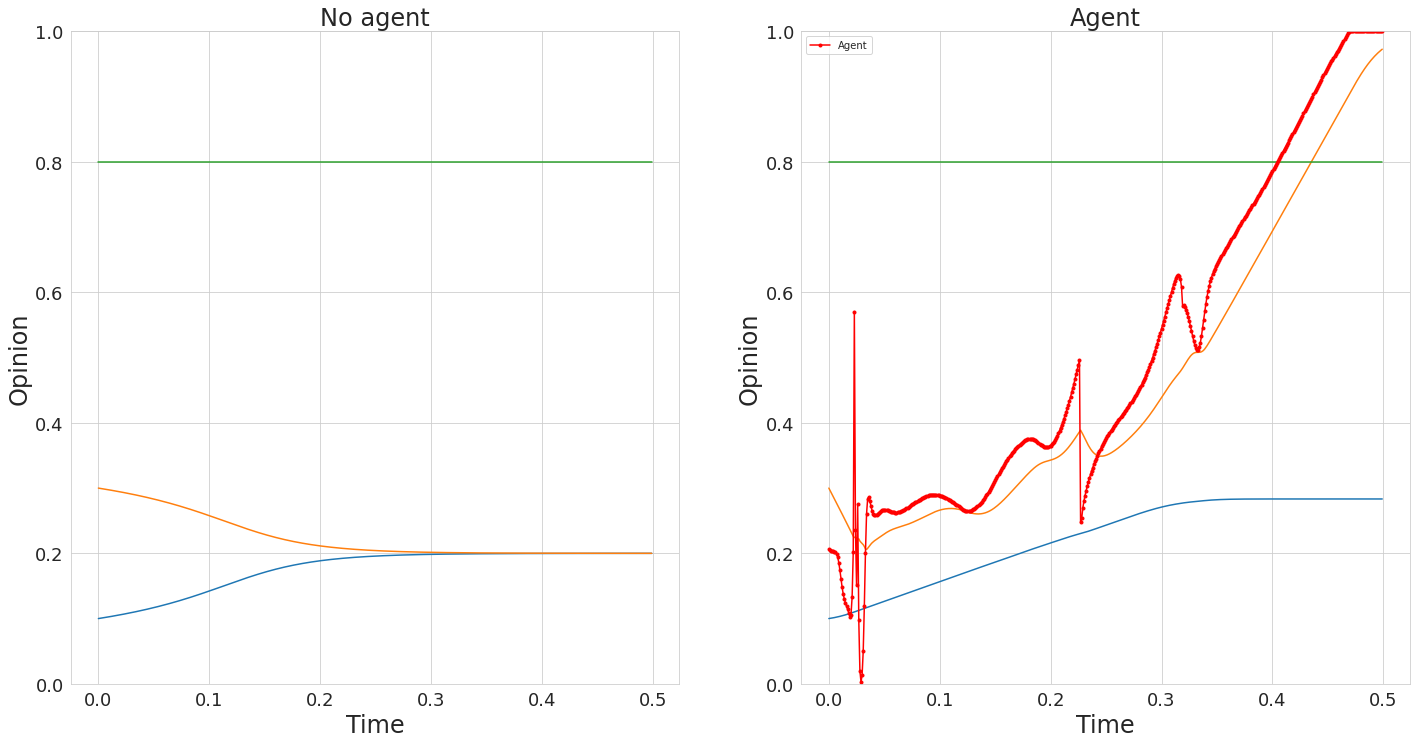

In [ ]:
#s%%time
(Opinions_no_agent,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, {}, nsteps, tstep)
(Opinions_agent,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
if n> 100:
  plot_opinion_quantiles(T,Opinions_no_agent)
else:
  plt.plot(T,Opinions_no_agent)


plt.title(f"No agent", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.ylim([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.subplot(1,2,2)
if n> 100:
  plot_opinion_quantiles(T,Opinions_agent)
else:
  plt.plot(T,Opinions_agent)
for i in range(nagents):
  if i ==0:
    plt.plot(T,Agent_opinions[:,i],marker='.',label=f'Agent',color ='red')
  else:
    plt.plot(T,Agent_opinions[:,i],marker='.',color ='red')


plt.title(f"Agent", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.legend()
plt.ylim([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

### Plot final objective value and final opinion distribution w/ and w/o trained agent

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


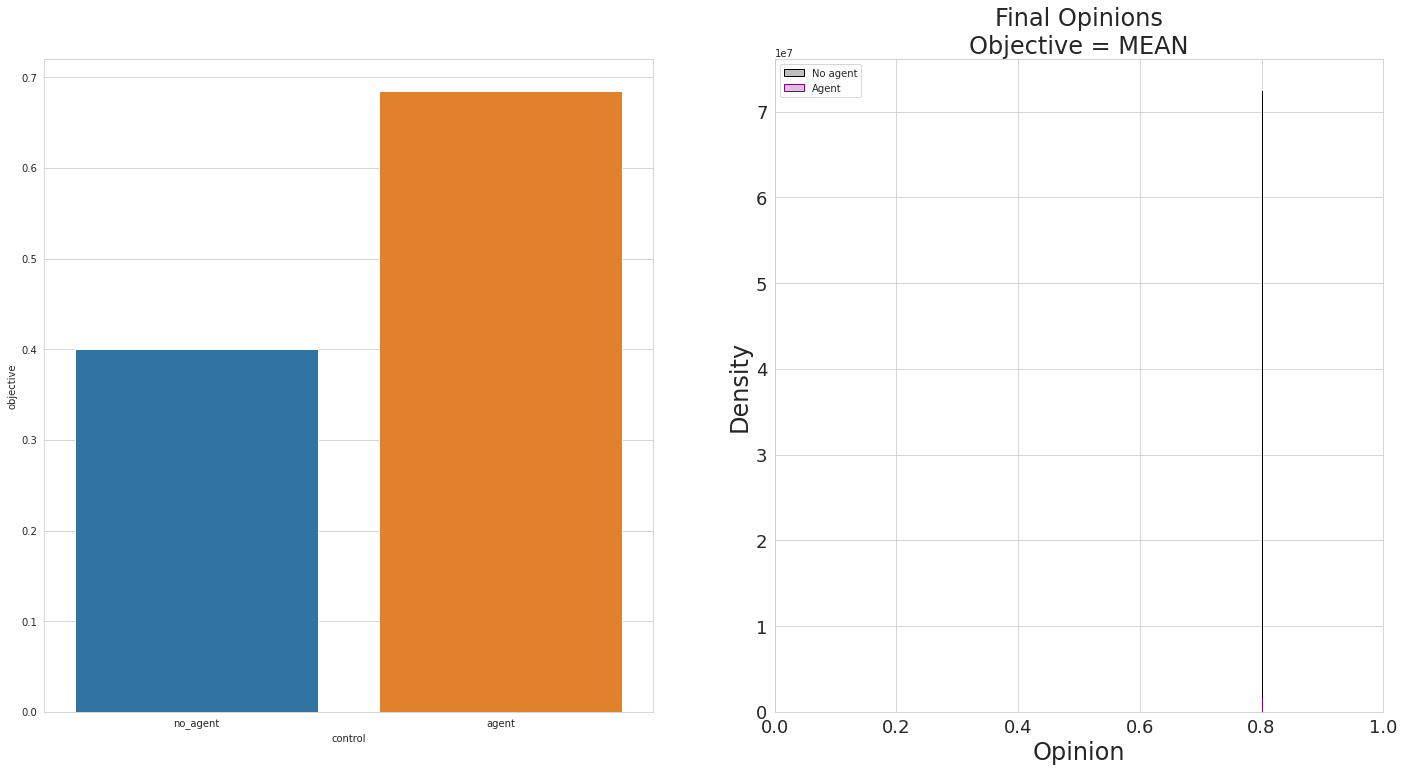

In [ ]:
objective_no_agent = objective_value(OBJECTIVE,Opinions_no_agent,opinion_target=0.5)
objective_agent = objective_value(OBJECTIVE,Opinions_agent,opinion_target=0.5)


data =  [{'control': 'no_agent', 'objective': -1*objective_no_agent}, 
        {'control': 'agent', 'objective': -1*objective_agent}] 
df_objective = pd.DataFrame(data)
df_opinions = pd.DataFrame({'opinions_agent':Opinions_agent[:,-1],'opinions_no_agent':Opinions_no_agent[:,-1]})

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
ax0 = sns.barplot(ax=axes[0],x="control", y="objective", data=df_objective)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("", fontsize = 24)
plt.ylabel(OBJECTIVE, fontsize = 24)

ax1= sns.distplot(df_opinions.opinions_no_agent, hist=False, rug=False, color = 'black' , ax=axes[1],kde_kws={"shade": True},label = 'No agent')
sns.distplot(df_opinions.opinions_agent, hist=False, rug=False, color = 'purple' , ax=axes[1],kde_kws={"shade": True},label = 'Agent')
ax1.set(xlabel='Opinions', ylabel='Count',title = f"Objective = {OBJECTIVE}")
ax1.legend(loc = 2)
plt.xlim([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Opinion", fontsize = 24)
plt.ylabel("Density", fontsize = 24)
plt.title(f"Final Opinions\nObjective = {OBJECTIVE}", fontsize = 24)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


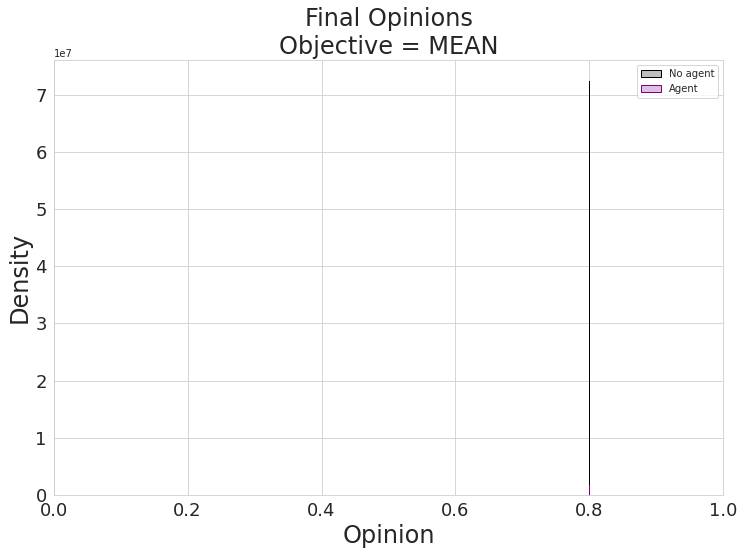

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(df_opinions.opinions_no_agent, hist=False, rug=False, color = 'black' , kde_kws={"shade": True},label = 'No agent')
sns.distplot(df_opinions.opinions_agent, hist=False, rug=False, color = 'purple' , kde_kws={"shade": True},label = 'Agent')
#ax1.set(xlabel='Opinions', ylabel='Count',title = f"Objective = {OBJECTIVE}")
#ax1.legend(loc = 2)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Opinion", fontsize = 24)
plt.ylabel("Density", fontsize = 24)
plt.title(f"Final Opinions\nObjective = {OBJECTIVE}", fontsize = 24)

plt.legend()
plt.xlim([0,1])
plt.show()

## Gilets Jaunes Dataset

### Load data into dataframe

In [ ]:
path = '/content/drive/My Drive/SocialNetworkAndOpinionDatasets/'
path_figures = path + "figures/"
path_data = path+"GiletsJaunes/"
fname_network_no_agent = path_data+"GiletsJaunes_sample_02_no_agent.csv"
fname_targets = path_data+"GiletsJaunes_sample_02_output_max_variance.csv"

df_no_agent = pd.read_csv(fname_network_no_agent)
df_no_agent.set_index('user_id',inplace=True)
df_targets = pd.read_csv(fname_targets)

FileNotFoundError: ignored

### Convert dataframe into networkx object

In [ ]:
def create_network_from_df(df):
  V = set(df.index.to_list())
  G = nx.DiGraph()
  for index,row in df.iterrows():
    u = index
    bot = row.bot
    opinion = row.opinion_tweet
    G.add_node(u, bot = bot, opinion = opinion )
    if type(row.friend_names)!=float:
      following = [x for x in row.friend_names.split(",")]
      for v in following:
        if v in V:
          G.add_edge(v,u)
  return G
G0 = create_network_from_df(df_no_agent)

n = G0.number_of_nodes()

Opinions0 = df_no_agent.opinion_tweet
Rates = df_no_agent.rate
A = nx.adjacency_matrix(G0)
A = A.tocoo()

#create followers_list and node_index
node_index = {}
Followers_list = []
for cnt,v in enumerate(G0.nodes()):
  node_index[v] = cnt

NameError: ignored

### Define Agent parameters

In [ ]:
#Agent parameters
Targets = [[str(int(x)) for x in df_targets.Target[1:].to_list()]]
agent_rates = [df_no_agent.rate.mean()]
nagents = len(agent_rates)

assert len(Targets)==len(agent_rates)
Targets_index = []
for targets in Targets:
  targets_index =[]
  for v in targets:
    try:
      targets_index.append(node_index[v])
    except:
      pass
  Targets_index.append(targets_index)
  

for cnt,v in enumerate(G0.nodes()):
  followers = list(G0.successors(v))
  Followers_list.append([node_index[u] for u in followers])
 



print(f"{n} nodes, {len(Targets_index[0])} targets for {nagents} agents")


### Run simulation with no agent

In [ ]:
## Select duration of simulation
ndays = 90 #Gilets Jaunes data was collected for 90 days
tau0_minutes = ndays/df_no_agent.rate.sum() * 24*60  #fundamental time unit 
print(f"tau0 = {tau0_minutes:.2f} minutes = avg time between tweets in entire network ")
tstep = tau0_minutes/10000 #tstep = time step for the simulation in [time units]. This is dt in the Euler step.  x(t+tstep) = x(t)+tstep*dx/dt
nsteps = 1000  #number of discrete steps in the simulation
tmax = nsteps*tstep
print(f"nsteps = {nsteps}\ntmax = {tmax:.1f} minutes\ntstep = {tstep:.2f} minutes")

In [ ]:
%%time

Agent_opinions = 1*np.ones((nsteps,nagents))  #give some dummy policy for agent 
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, [], nsteps, tstep)
#set the boundary condition for adjoint variables
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse given final boundary condtion Pf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, [], nsteps, tstep)





In [ ]:
#Plot opinions and adjoint varibles
if n> 100:
  plot_opinion_P_quantiles(T,Opinions,Agent_opinions,P)
else:
   plot_opinion_P(T,Opinions,P,Agent_opinions)

In [ ]:
plt.figure(figsize=(12,8))
x=np.concatenate((Opinions[0,:],Opinions[-1,:]),axis = 0)
l = ['Initial' for x in range(Opinions.shape[1])]+['Final: no agent' for x in range(Opinions.shape[1])]
df_opinions_no_agent = pd.DataFrame({'Opinion':x,'Condition':l})
sns.kdeplot(data=df_opinions_no_agent , x="Opinion",fill = True,hue='Condition')
plt.xlabel('Opinion',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,1])
plt.show()
y0 = df_opinions_no_agent[df_opinions_no_agent.Condition=='Initial'].var().values[0]
y1 = df_opinions_no_agent[df_opinions_no_agent.Condition=='Final: no agent'].var().values[0]
print(f"Initial variance = {y0:.4f}, Final variance (no agent) = {y1:.4f}")

### Initialize Agent Opinions to minimum or maximum of their followers

In [ ]:
Agent_opinions = np.ones((nsteps,nagents))  #initialize policy for agent 
for cnt in range(nagents):
  #Make the dictionary Targets_index for faster lookup
  targets_index = Targets_index[cnt]
  Opinions_followers = Opinions[:,targets_index]
  #agent opinion equals minimum of its followers at each time step
  Agent_opinions[:,cnt] = np.quantile(Opinions_followers,0.99,axis =1)


### Simulate opinions using initial agent guess
You will want to simulate with the initial agent guess to make sure you started from a good initial condition.  This helps with the optimization.

In [ ]:
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
if n> 100:
  plot_opinion_P_quantiles(T,Opinions,Agent_opinions,P)
else:
   plot_opinion_P(T,Opinions,P,Agent_opinions)



### Find optimal policy via ADAM

Run this loop to iteratively improve the agent_opion policy using
ADAM.  You will have to choose the step size for the gradient step, the ADAM parameters, and the initial guess of the agent_opinion.  It's best to set the agent's opinion equal to the minumum or maximum initial opinion.  This way you have some gradient to start with.

In [ ]:
%%time
#Choose objective:  this will be minimized by the agent
OBJECTIVE = 'VARIANCE'  #OBJECTIVE can be "MEAN" (maximize mean), "VARIANCE" (maximize variance), "TARGET" (minimize RMS to target opinion)
opinion_target = 0.5 #in case you use the TARGET objective


#Set gradient step size and number of gradient step iterations
niter = 100  #number of iterations for ADAM optimizer
plot_step = 10  #how frequently to plot agent opinion

alpha = 0.1
STOP_TOLERANCE = 1e-3  #fractional change in objective you will stop at
#ADAM parameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

#Initialize ADAM parameters
M_old = np.zeros((nsteps,nagents))
V_old = np.zeros((nsteps,nagents))

#Initialize objective array
Objective = np.zeros(niter)
objective_old = 0

#Initialize array of Agent opinions for each iteration.  We can use this to see our agent get smarter
Agent_opinion_iterations = np.zeros((nsteps,nagents,niter))

for i in range(0,niter):  
  #add current agents policy at current iteration
  for cnt in range(nagents):
    Agent_opinion_iterations[:,cnt,i] = Agent_opinions[:,cnt]

  #simulate opinion dynamics
  (Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
  #Set boundary condition on adjoint (depends on objective)
  Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
  (P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)


  
  #update objective
  if OBJECTIVE == "MEAN":
    objective = -np.mean(Opinions[-1,:])  #maximize mean
  elif OBJECTIVE == "VARIANCE":
    objective = -np.var(Opinions[-1,:])  #maximize variance
  elif OBJECTIVE == "TARGET":
    objective = np.sum((Opinions[-1,:]-opinion_target)**2)  #hit a target opinion
  Objective[i] = objective
  
  #plot opinions under current agent opinion policy
  if i%plot_step==0:
    print(f"Iter. {i}: objective = {objective:.4f}")
    #print(f"\tgrad step  {grad_step:.5f}")
    if n> 100:
      plot_opinion_P_quantiles(T,Opinions,Agent_opinions,P)
    else:
      plot_opinion_P(T,Opinions,P,Agent_opinions)

  # check if objective changed sufficiently.  If it didnt, STOP
  normalized_change = np.abs(objective_old-objective)/(1e-10 + np.abs(objective_old))
  if normalized_change<0*STOP_TOLERANCE:
    print(f"Iter. {i}: objective = {objective:.2f}: STOP")
    break

  
  # If we didnt STOP, let's update the agent's opinion policy
  Agent_opinions_new = np.zeros((nsteps,nagents))
  for cnt in range(nagents):
    #update agent opinion policy using ADAM update rule
    grad_step = alpha/np.sqrt(i+1)  #the step size you multiply by the ADAM gradient to get the update for the agent policy
    (DHa, Ma, Va) = H_step_ADAM(Opinions, Agent_opinions[:,cnt], agent_rates[cnt], Targets_index[cnt], beta1, beta2, M_old[:,cnt], V_old[:,cnt], epsilon,i)
    
    #clip DH to avoid huge oscillations in the updated policy
    DHa_clip =  np.maximum(-0.1,np.minimum(0.1,grad_step*DHa))
    Agent_opinions_new[:,cnt] = Agent_opinions[:,cnt] - DHa_clip

    #Clip the agent opinion so it is between 0 and 1
    Agent_opinions_new = np.maximum(0,np.minimum(1,Agent_opinions_new))
    M_old[:,cnt] = Ma
    V_old[:,cnt] = Va
  
  #update the agent opinions and the old objective
  Agent_opinions = Agent_opinions_new  
  objective_old = objective


print("DONE WITH LEARNING POLICY!!")
#run simulation with final agent opinion
(Opinions,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)
#Set boundary condition on adjoint (depends on objective)
Pf = boundary_condition_Pf(OBJECTIVE,Opinions)
#simulate adjoint dynamics in reverse with boundary condition Pf at time tf
(P,T) = simulate_adjoint_reverse(Pf, Opinions, Rates, A, Agent_opinions,agent_rates, Targets_index, nsteps, tstep)


plt.figure(figsize =(12,8))
plt.plot(-Objective,marker='.',color = 'red')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Opinion variance",fontsize = 24)
plt.xlabel('Training iteration',fontsize = 24)
plt.show()







### Plot opinions without and with trained agent

In [ ]:
#s%%time
(Opinions_no_agent,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, {}, nsteps, tstep)
(Opinions_agent,T) = simulate_opinion(Opinions0, Rates, A, Agent_opinions, agent_rates, Targets_index, nsteps, tstep)

plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
if n> 100:
  plot_opinion_quantiles(T,Opinions_no_agent)
else:
  plt.plot(T,Opinions_no_agent)


plt.title(f"No agent", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.ylim([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.subplot(1,2,2)
if n> 100:
  plot_opinion_quantiles(T,Opinions_agent)
else:
  plt.plot(T,Opinions_agent)
for i in range(nagents):
  if i ==0:
    plt.plot(T,Agent_opinions[:,i],marker='.',label=f'Agent',color ='red')
  else:
    plt.plot(T,Agent_opinions[:,i],marker='.',color ='red')


plt.title(f"Agent", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.legend()
plt.ylim([0,1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()




### Plot final objective value and final opinion distribution w/ and w/o trained agent

In [ ]:
objective_no_agent = objective_value(OBJECTIVE,Opinions_no_agent,opinion_target=0.5)
objective_agent = objective_value(OBJECTIVE,Opinions_agent,opinion_target=0.5)


data =  [{'control': 'no_agent', 'objective': -1*objective_no_agent}, 
        {'control': 'agent', 'objective': -1*objective_agent}] 
df_objective = pd.DataFrame(data)

plt.figure(figsize=(12,8))
x=Opinions[-1,:]
l = ['Final: agent' for x in range(Opinions.shape[1])]
df_opinions_agent = pd.DataFrame({'Opinion':x,'Condition':l})

df_opinions = pd.concat([df_opinions_no_agent,df_opinions_agent])





fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(x="control", y="objective", data=df_objective)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("", fontsize = 20)
plt.ylabel(OBJECTIVE, fontsize = 20)


fig = plt.figure(figsize=(12, 8))
ax = sns.kdeplot(data=df_opinions[df_opinions.Condition!='Initial'], x="Opinion",fill = True,hue='Condition')
plt.xlabel('Opinion',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,1])
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.show()
y0 = df_opinions[df_opinions.Condition=='Initial'].var().values[0]
y1 = df_opinions[df_opinions.Condition=='Final: no agent'].var().values[0]
y2 = df_opinions[df_opinions.Condition=='Final: agent'].var().values[0]

print(f"Initial variance = {y0:.4f}\nFinal variance (no agent) = {y1:.4f}\nFinal variance (agent) = {y2:.4f}")

plt.show()